# Beijing Air Quality Forecasting Notebook

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import LSTM, Dense,Dropout, Bidirectional,BatchNormalization,LayerNormalization
import tensorflow as tf
from tensorflow.keras.regularizers import l2,l1
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [ ]:
# Load the datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [ ]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30676 entries, 0 to 30675
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   No        30676 non-null  int64  
 1   DEWP      30676 non-null  float64
 2   TEMP      30676 non-null  float64
 3   PRES      30676 non-null  float64
 4   Iws       30676 non-null  float64
 5   Is        30676 non-null  float64
 6   Ir        30676 non-null  float64
 7   datetime  30676 non-null  object 
 8   cbwd_NW   30676 non-null  float64
 9   cbwd_SE   30676 non-null  float64
 10  cbwd_cv   30676 non-null  float64
 11  pm2.5     28755 non-null  float64
dtypes: float64(10), int64(1), object(1)
memory usage: 2.8+ MB


In [ ]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [ ]:
# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])

test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)


# Handle missing values


- Check the dataset for missing values and decide how to handle them.


In [ ]:
train.isnull().sum()

,0
No,0
DEWP,0
TEMP,0
PRES,0
Iws,0
Is,0
Ir,0
cbwd_NW,0
cbwd_SE,0
cbwd_cv,0


In [ ]:
test.isnull().sum()

,0
No,0
DEWP,0
TEMP,0
PRES,0
Iws,0
Is,0
Ir,0
cbwd_NW,0
cbwd_SE,0
cbwd_cv,0


In [58]:
#filling in the missing values with mean
train.fillna(train.mean(), inplace=True)

In [ ]:
train.isnull().sum()

,0
No,0
DEWP,0
TEMP,0
PRES,0
Iws,0
Is,0
Ir,0
cbwd_NW,0
cbwd_SE,0
cbwd_cv,0


## Visualing Data to find insights

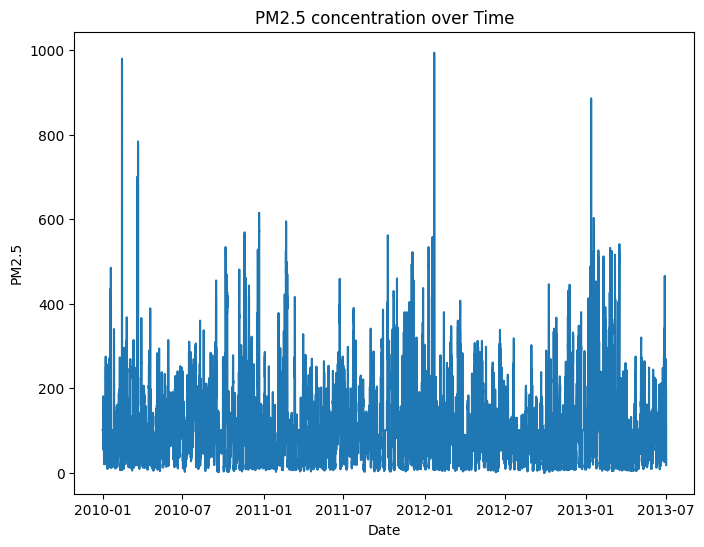

In [ ]:
#PM2.5 Concentration over time
plt.figure(figsize=(8,6))
plt.plot(train.index,train['pm2.5'],label='PM2.5')
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.title('PM2.5 concentration over Time')
plt.savefig("PM25 concentration over Time")
plt.show()

From the diagram, PM2.5 levels often spike and show signs of seasonal patterns, especially in colder months, this suggests that air quality is affected by many factors. This high variation means simple models may not work well, and more advanced machine learning methods like LSTM will be best for accurate predictions.

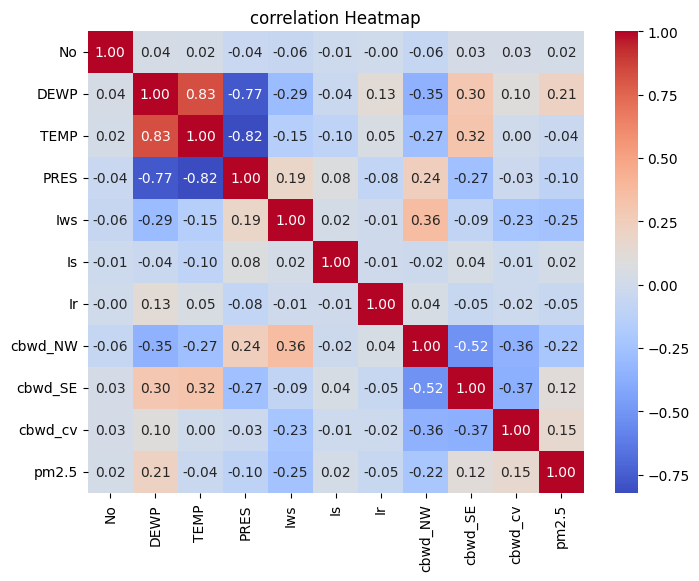

In [ ]:
#correlation heatmap
plt.figure(figsize=(8,6))
correlation = train.corr(numeric_only= True)
sns.heatmap(correlation,annot=True,cmap="coolwarm",fmt='.2f')
plt.title('correlation Heatmap')
plt.savefig("correlation heatmap")
plt.show()

From the correlation heatmap,Environmental variables like temperature, dew point, and pressure exhibit strong interrelationships.
However,As shown; none of them show a strong direct correlation with pm2.5, suggesting that air pollution levels are likely affected by multiple factors.


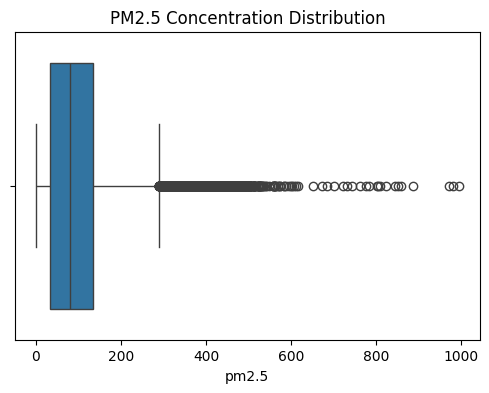

In [ ]:
# Box plot of PM2.5 Concentration Distribution
plt.figure(figsize=(6, 4))
sns.boxplot(x=train['pm2.5'])
plt.title('PM2.5 Concentration Distribution')
plt.savefig("PM2 Distribution")
plt.show()


From the Box plot; we can see that the data is right-skewed, meaning thereare many many high PM2.5 values that doesn't  of the general trend.
It also shows many outliers; most of the PM2.5 readings above 400 are far from the median and can negatively impact your models performance.

# Checking for outliers




In [ ]:
#From the box plot, there were many outliers, this is to find the outliers and fix it, if not it will affect the model performance
Q1 = train['pm2.5'].quantile(0.25)
Q3 = train['pm2.5'].quantile(0.75)
IQR = Q3 - Q1

# Defining the quartiles
lower_quartile = Q1 - 1.5 * IQR
upper_quartile = Q3 + 1.5 * IQR

# Identifying outliers
outliers = train[(train['pm2.5'] < lower_quartile) | (train['pm2.5'] > upper_quartile)]
print(f"Initial Outliers detected: {outliers.shape[0]} rows")

Initial Outliers detected: 1335 rows


In [ ]:
# fixing the outliers using clipping method
train['pm2.5'] = train['pm2.5'].clip(lower=lower_quartile, upper=upper_quartile)

In [ ]:
#final check to see if outliers still exist after clipping
outliers = train[(train['pm2.5'] < lower_quartile) | (train['pm2.5'] > upper_quartile)]
print(f"Outliers detected After Handling: {outliers.shape[0]} rows")


Outliers detected After Handling: 0 rows


In [ ]:
#finding the value range of PM2.5
print("Min:", train['pm2.5'].min())
print("Max:", train['pm2.5'].max())

# statistical summary
print(train['pm2.5'].describe())

Min: 0.0
Max: 289.5
count    30676.000000
mean        96.917743
std         77.341339
min          0.000000
25%         32.000000
50%         81.000000
75%        135.000000
max        289.500000
Name: pm2.5, dtype: float64


# Separate features and target


In [ ]:
# creating additional datetime-based features
train['hour'] = train.index.hour
train['day'] = train.index.day
train['month'] = train.index.month
train['weekday'] = train.index.weekday
test['hour'] = test.index.hour
test['day'] = test.index.day
test['month'] = test.index.month
test['weekday'] = test.index.weekday

In [ ]:
train.head(5)

,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5,hour,day,month,weekday
datetime,,,,,,,,,,,,,,,
2010-01-01 00:00:00,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,100.793427,0,1,1,4
2010-01-01 01:00:00,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,100.793427,1,1,1,4
2010-01-01 02:00:00,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,100.793427,2,1,1,4
2010-01-01 03:00:00,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,100.793427,3,1,1,4
2010-01-01 04:00:00,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,100.793427,4,1,1,4


In [ ]:
train.shape

(30676, 15)

In [ ]:
test.head(5)

,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,hour,day,month,weekday
datetime,,,,,,,,,,,,,,
2013-07-02 04:00:00,30677,1.190496,0.701029,-2.186052,-0.003982,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,4,2,7,1
2013-07-02 05:00:00,30678,1.121211,0.619051,-2.186052,0.031811,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,5,2,7,1
2013-07-02 06:00:00,30679,1.190496,0.783006,-2.186052,0.094398,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,6,2,7,1
2013-07-02 07:00:00,30680,1.190496,0.946961,-2.088668,0.174782,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,7,2,7,1
2013-07-02 08:00:00,30681,1.190496,1.192893,-1.991283,0.210575,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,8,2,7,1


In [ ]:
test.shape

(13148, 14)

In [ ]:
# Separate features and target
X_train = train.drop(['pm2.5', 'No'], axis=1)
y_train = train['pm2.5']
X_test = test.drop(['No'], axis=1)

In [ ]:
# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Reshape data for LSTM input
X_train_scaled = np.expand_dims(X_train_scaled, axis=1)  #that is; (samples, timesteps, features)
X_test_scaled = np.expand_dims(X_test_scaled, axis=1)

In [ ]:
# Split data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_scaled, y_train, test_size=0.2, shuffle=False)


In [ ]:
X_train_split.shape

(24540, 1, 13)

In [ ]:
X_val_split.shape

(6136, 1, 13)

# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [ ]:

# Define model
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, activation='relu', kernel_regularizer=l2(0.0001)),input_shape=(X_train_split.shape[1], X_train_split.shape[2])
    ),
    LayerNormalization(),
    LSTM(64, return_sequences=True, activation='relu', kernel_regularizer=l2(0.0001)),
    LayerNormalization(),
    Dropout(0.3),
    LSTM(32, activation='relu', kernel_regularizer=l2(0.0001)),
    Dropout(0.2),
    Dense(64, activation='relu', kernel_regularizer=l2(0.0001)),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='mse',
)

# Display the model architecture
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 1, 256)         │       145,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 1, 256)         │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 64)          │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 1, 64)          │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,817 (948.50 KB)

 Trainable params: 242,817 (948.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# start time for the model training
start_time = time.time()

# Train the model
start_time = time.time()
history = model.fit(
    X_train_split, y_train_split,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_split, y_val_split),
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - loss: 7843.0991 - val_loss: 4059.0828 - learning_rate: 5.0000e-04
Epoch 2/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 3442.1978 - val_loss: 3785.6743 - learning_rate: 5.0000e-04
Epoch 3/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 3104.8848 - val_loss: 3427.2046 - learning_rate: 5.0000e-04
Epoch 4/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 2770.4553 - val_loss: 3289.5688 - learning_rate: 5.0000e-04
Epoch 5/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 2589.1279 - val_loss: 3356.6709 - learning_rate: 5.0000e-04
Epoch 6/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 2527.2371 - val_loss: 3202.1401 - learning_rate: 5.0000e-04
Epoch 7/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 2411.7207 - val_loss: 3395.3518 - learning_rate: 5.0000e-04
Epoch 8/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 2299.2632 - val_loss: 3322.8337 - learning_rate: 5.0000e-04
Epoch 9/50
767/767 ━━━━━━━━━━

In [ ]:
# Calculate training time
end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds")

Training Time: 111.82 seconds


767/767 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


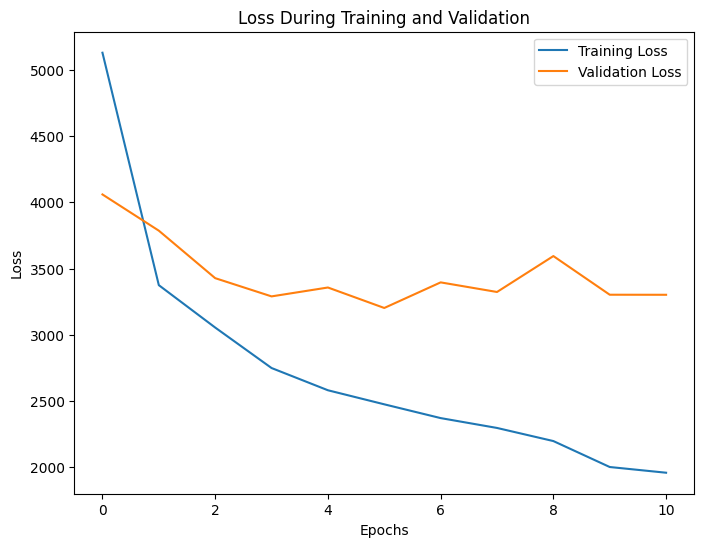

In [ ]:
# Evaluate model on training and validation set
train_predictions = model.predict(X_train_split)
val_predictions = model.predict(X_val_split)

# Visualize the training loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss During Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
#Loss and RMSE
train_loss = mean_squared_error(y_train_split, train_predictions)
val_loss = mean_squared_error(y_val_split, val_predictions)
RMSE = np.sqrt(train_loss)

print(f'Training Loss (MSE): {train_loss:.4f}')
print(f'Validation Loss (MSE): {val_loss:.4f}')
print(f'Root Mean Squared Error (RMSE): {RMSE:.4f}')

Training Loss (MSE): 1965.2694
Validation Loss (MSE): 3202.0853
Root Mean Squared Error (RMSE): 44.3314


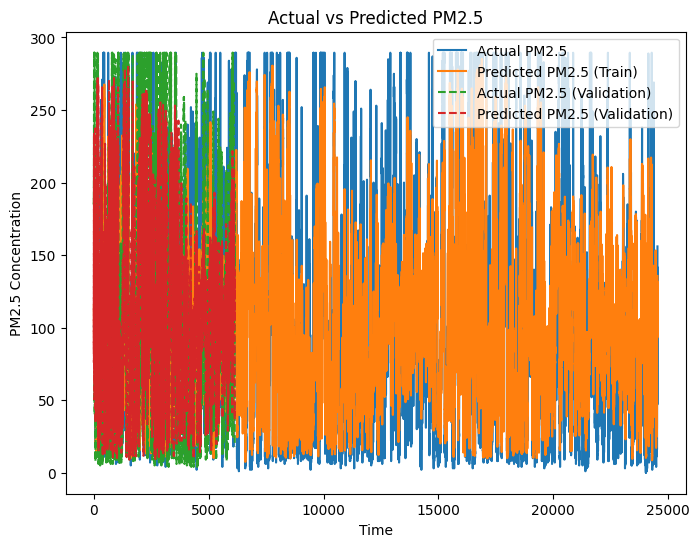

In [ ]:
# Visualize predictions vs actual values
plt.figure(figsize=(8, 6))
plt.plot(y_train_split.values, label='Actual PM2.5')
plt.plot(train_predictions.flatten(), label='Predicted PM2.5 (Train)')
plt.plot(y_val_split.values, label='Actual PM2.5 (Validation)', linestyle='--')
plt.plot(val_predictions.flatten(), label='Predicted PM2.5 (Validation)', linestyle='--')
plt.title('Actual vs Predicted PM2.5')
plt.xlabel('Time')
plt.ylabel('PM2.5 Concentration')
plt.legend()
plt.savefig("")
plt.show()

From the graph, the model is performing well in capturing general patterns in air quality but struggles in accurately predicting extreme events. Overall,it shows the model was able to learn the trend of the times series data but struggles to make prediction when it doesn't follow such trend.

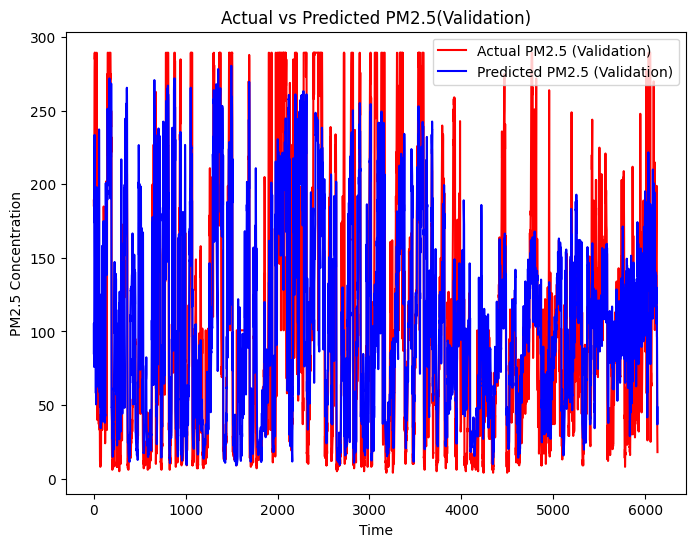

In [ ]:
# Visualize predictions vs actual values
plt.figure(figsize=(8, 6))
plt.plot(y_val_split.values, color='red', label='Actual PM2.5 (Validation)')
plt.plot(val_predictions.flatten(), color='blue', label='Predicted PM2.5 (Validation)')
plt.title('Actual vs Predicted PM2.5(Validation)')
plt.xlabel('Time')
plt.ylabel('PM2.5 Concentration')
plt.legend()
plt.savefig("Actual vs Predicted (Validation")
plt.show()

In [ ]:

# Make predictions on the test set
predictions = model.predict(X_test_scaled)

# Ensure predictions do not contain NaN values
predictions = np.nan_to_num(predictions)

# Convert predictions to integers
predictions = np.round(predictions).astype(int)

# Prepare the submission file
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %-H:%M:%S'),
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID' to match the solution file exactly
submission = submission.sort_values(by='row ID')

# Save the file in CSV format for submission on Kaggle
submission.to_csv('subm_fixed_13.csv', index=False)

411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
